In [1]:
import pandas as pd
import numpy as np
import re
from sklearn import preprocessing, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime as dt


In [2]:
df_drugs = pd.read_csv("Accidental_Drug_Related_Deaths_2012-2018.csv")
df_drugs.head()

,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,...,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,MannerofDeath,DeathCityGeo,ResidenceCityGeo,InjuryCityGeo,Town Index
0,14-0273,06/28/2014 12:00:00 AM,DateReported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Accident,"CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)",83.0
1,13-0102,03/21/2013 12:00:00 AM,DateofDeath,48.0,Male,Black,NORWALK,NaN,NaN,NORWALK,...,NaN,NaN,NaN,NaN,NaN,Accident,"Norwalk, CT\n(41.11805, -73.412906)","NORWALK, CT\n(41.11805, -73.412906)","CT\n(41.575155, -72.738288)",103.0
2,16-0165,03/13/2016 12:00:00 AM,DateofDeath,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,...,NaN,NaN,NaN,NaN,Y,Accident,"Danbury, CT\n(41.393666, -73.451539)","SANDY HOOK, CT\n(41.419998, -73.282501)",NaN,34.0
3,16-0208,03/31/2016 12:00:00 AM,DateofDeath,23.0,Male,White,RYE,WESTCHESTER,NY,GREENWICH,...,NaN,NaN,NaN,NaN,Y,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,NaN,57.0
4,13-0052,02/13/2013 12:00:00 AM,DateofDeath,22.0,Male,"Asian, Other",FLUSHING,QUEENS,NaN,GREENWICH,...,NaN,NaN,NaN,NaN,NaN,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,"CT\n(41.575155, -72.738288)",57.0


# Overdose Data

## Load and process

In [3]:
df_overdoses = pd.read_csv("overdoses.csv")
df_overdoses.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


In [4]:
# Let's start out by removing the ',' from our numbers in the Deaths and Population columns so that we can use them as integers
df_overdoses['Deaths'] = df_overdoses['Deaths'].str.replace(',', '')
df_overdoses['Deaths'] = df_overdoses['Deaths'].astype(int)
df_overdoses['Population'] = df_overdoses['Population'].str.replace(',', '')
df_overdoses['Population'] = df_overdoses['Population'].astype(int)
# Sort by State
df_overdoses = df_overdoses.sort_values(by='State')

In [5]:
#Adding an additional column where we see the deaths per capita per each state
df_overdoses['mortality_rate'] = (df_overdoses['Deaths']/df_overdoses['Population'])*100
#Let's check to see that it worked!

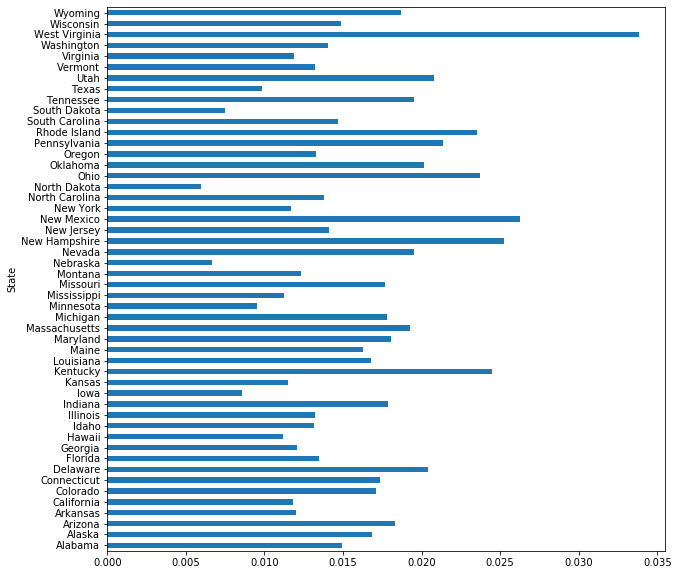

In [6]:
#How many opioid deaths by U.S. state?
df_overdoses.set_index('State')['mortality_rate'].plot.barh(figsize=(10, 10))

# Prescriber tracking

## Load and process

In [7]:
df_prescriber = pd.read_csv("prescriber-info.csv")
df_prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [8]:
df_opioids = pd.read_csv("opioids.csv")
df_opioids.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [9]:
opioidsincols = []
for drug in df_prescriber.columns:
    drug_part_name = drug.lower().split('.')[0]
    isopioid = df_opioids['Drug Name'].apply(lambda x: len(re.findall(drug_part_name, x.lower())) > 0).any()
    
    if isopioid:
        print(drug, drug_part_name, isopioid)
        opioidsincols.append(drug)

ACETAMINOPHEN.CODEINE acetaminophen True
CARISOPRODOL carisoprodol True
FENTANYL fentanyl True
HYDROCODONE.ACETAMINOPHEN hydrocodone True
HYDROMORPHONE.HCL hydromorphone True
IBUPROFEN ibuprofen True
METHADONE.HCL methadone True
MORPHINE.SULFATE morphine True
MORPHINE.SULFATE.ER morphine True
OXYCODONE.ACETAMINOPHEN oxycodone True
OXYCODONE.HCL oxycodone True
OXYCONTIN oxycontin True
TRAMADOL.HCL tramadol True


In [10]:
keepcols = df_prescriber.columns[:5].to_list()
keepcols.extend(opioidsincols)
keepcols

['NPI',
 'Gender',
 'State',
 'Credentials',
 'Specialty',
 'ACETAMINOPHEN.CODEINE',
 'CARISOPRODOL',
 'FENTANYL',
 'HYDROCODONE.ACETAMINOPHEN',
 'HYDROMORPHONE.HCL',
 'IBUPROFEN',
 'METHADONE.HCL',
 'MORPHINE.SULFATE',
 'MORPHINE.SULFATE.ER',
 'OXYCODONE.ACETAMINOPHEN',
 'OXYCODONE.HCL',
 'OXYCONTIN',
 'TRAMADOL.HCL']

In [11]:
# Remove other meds and keep only Opioids
df_prescriber = df_prescriber[keepcols]
# Sum the total amount of opioids precribed by each doctor
df_prescriber['total_prescription'] = df_prescriber[opioidsincols].sum(axis=1)

In [12]:
df_prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ACETAMINOPHEN.CODEINE,CARISOPRODOL,FENTANYL,HYDROCODONE.ACETAMINOPHEN,HYDROMORPHONE.HCL,IBUPROFEN,METHADONE.HCL,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,TRAMADOL.HCL,total_prescription
0,1710982582,M,TX,DDS,Dentist,0,0,0,17,0,0,0,0,0,0,0,0,0,17
1,1245278100,F,AL,MD,General Surgery,0,45,0,182,0,0,0,0,24,33,87,0,36,407
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1669567541,M,AZ,MD,Internal Medicine,43,0,0,0,0,15,0,22,146,229,29,0,90,574
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,22,22,0,0,0,0,0,0,22,0,0,66


In [16]:
df_prescriber.sort_values(by='total_prescription', ascending=False)

,NPI,Gender,State,Credentials,Specialty,ACETAMINOPHEN.CODEINE,CARISOPRODOL,FENTANYL,HYDROCODONE.ACETAMINOPHEN,HYDROMORPHONE.HCL,IBUPROFEN,METHADONE.HCL,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,TRAMADOL.HCL,total_prescription
14265,1831150630,M,FL,M.D.,Interventional Pain Management,55,955,1292,4262,532,26,266,718,2404,2675,1629,511,890,16215
9936,1750364121,M,LA,MD,Physical Medicine and Rehabilitation,0,0,435,5249,25,64,162,494,1904,3127,2577,514,187,14738
14389,1215199609,M,FL,DO,Anesthesiology,31,412,297,1193,226,89,198,231,1118,1208,1017,187,87,6294
17624,1225069065,M,LA,M.D.,Interventional Pain Management,20,146,632,2965,29,0,244,20,204,1256,105,90,438,6149
23823,1053392571,M,IN,MD,Pain Management,0,0,312,2171,86,12,512,0,908,1158,327,276,140,5902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7073,1710293584,M,AA,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16126,1245661214,F,WI,PA-C,Physician Assistant,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16127,1508065848,M,MI,M.D.,Cardiac Electrophysiology,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16128,1447211586,M,MD,M.D.,Cardiology,0,0,0,0,0,0,0,0,0,0,0,0,0,0


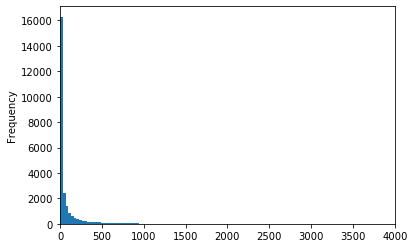

In [23]:
df_prescriber.sort_values(by='total_prescription', ascending=False)['total_prescription'].plot.hist(bins=500, xlim=(0,4000))

In [33]:
dfbaddoc = df_prescriber[df_prescriber['total_prescription'] > 1500]

In [44]:
dfbaddoc.sort_values(by='total_prescription', ascending=False)

,NPI,Gender,State,Credentials,Specialty,ACETAMINOPHEN.CODEINE,CARISOPRODOL,FENTANYL,HYDROCODONE.ACETAMINOPHEN,HYDROMORPHONE.HCL,IBUPROFEN,METHADONE.HCL,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,TRAMADOL.HCL,total_prescription
14265,1831150630,M,FL,M.D.,Interventional Pain Management,55,955,1292,4262,532,26,266,718,2404,2675,1629,511,890,16215
9936,1750364121,M,LA,MD,Physical Medicine and Rehabilitation,0,0,435,5249,25,64,162,494,1904,3127,2577,514,187,14738
14389,1215199609,M,FL,DO,Anesthesiology,31,412,297,1193,226,89,198,231,1118,1208,1017,187,87,6294
17624,1225069065,M,LA,M.D.,Interventional Pain Management,20,146,632,2965,29,0,244,20,204,1256,105,90,438,6149
23823,1053392571,M,IN,MD,Pain Management,0,0,312,2171,86,12,512,0,908,1158,327,276,140,5902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,1528034410,M,MS,MD,Rheumatology,0,35,0,969,0,11,0,0,0,13,0,0,493,1521
19468,1144262239,F,WA,ARNP,Nurse Practitioner,0,71,67,48,77,0,208,0,203,16,698,128,0,1516
13194,1134203904,M,GA,M.D.,Family Practice,30,151,45,846,20,29,0,0,25,43,208,17,102,1516
20934,1588661458,M,KY,M.D.,Family Practice,0,59,25,740,48,18,0,0,47,251,39,78,209,1514


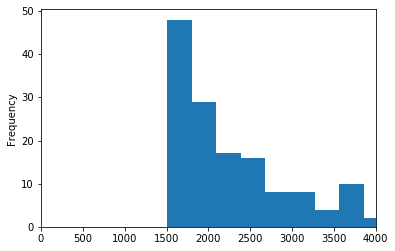

In [35]:
dfbaddoc['total_prescription'].plot.hist(bins=50, xlim=(0,4000))

In [39]:
dfbaddoc['Gender'].value_counts()

M    126
F     28
Name: Gender, dtype: int64

In [40]:
dfbaddoc['State'].value_counts()

FL    14
CA    14
TX    10
NC     9
AL     8
GA     8
AZ     7
MI     7
IN     6
PA     6
KY     6
LA     6
OH     5
NY     5
TN     4
KS     3
WA     3
OK     3
IL     3
MO     3
NV     2
WI     2
AR     2
MS     2
WV     2
MD     2
SC     2
VA     2
OR     2
NJ     1
ID     1
CO     1
MA     1
NE     1
IA     1
Name: State, dtype: int64

In [43]:
dfbaddoc['Specialty'].value_counts()

Internal Medicine                       33
Family Practice                         29
Nurse Practitioner                      15
Physical Medicine and Rehabilitation    15
Pain Management                         13
Anesthesiology                          13
Interventional Pain Management           9
Physician Assistant                      8
Rheumatology                             5
Neurology                                3
Emergency Medicine                       2
General Practice                         2
Orthopedic Surgery                       2
Osteopathic Manipulative Medicine        1
General Surgery                          1
Geriatric Medicine                       1
Addiction Medicine                       1
Infectious Disease                       1
Name: Specialty, dtype: int64